# week0_05: Decision Trees

This practice notebook is based on Evgeny Sokolov's <a href="https://github.com/esokolov/ml-course-hse/blob/master/2017-fall/seminars/sem07-trees.ipynb">materials</a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeRegressor

First, let's generate the dataset.

In [2]:
rng = np.random.RandomState(1)

X = np.sort(5 * rng.rand(80, 1), axis=0)
y = np.sin(X).ravel()  # plane sinus function
y[::5] += 3 * (0.5 - rng.rand(16))  # add random outliers

And then train our basic models: Decision Tree regressors with different depth.

In [3]:
regr_tree_2 = DecisionTreeRegressor(max_depth=2)
regr_tree_2.fit(X, y)

regr_tree_5 = DecisionTreeRegressor(max_depth=5)
regr_tree_5.fit(X, y)

DecisionTreeRegressor(max_depth=5)

Once we have our models, we are able to retrieve predictions.

In [4]:
grid = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
pred_surface_2 = regr_tree_2.predict(grid)
pred_surface_5 = regr_tree_5.predict(grid)

Let's visualize the results. Does the model fit data well? Which parameter is better?

How does maximum depth influence the solution?

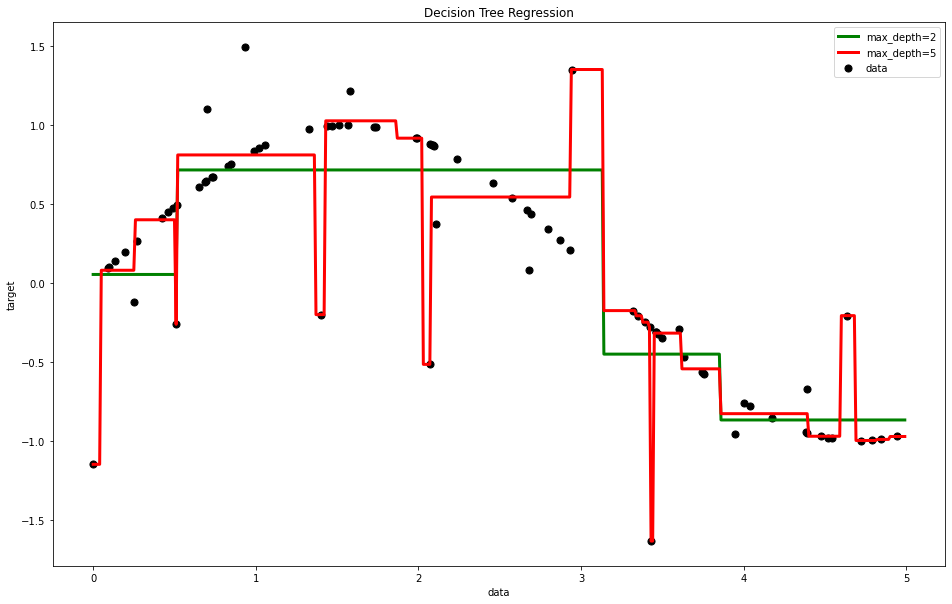

In [5]:
plt.figure(figsize=(16, 10))

plt.scatter(X, y, s=50, color="black", label="data")
plt.plot(grid, pred_surface_2, color="green", label="max_depth=2", linewidth=3)
plt.plot(grid, pred_surface_5, color="red", label="max_depth=5", linewidth=3)

plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

# Informativity criteria

Let
* $R_m$ - a set of all training data objects that refer to the node $m$, 
* $N_m=|R_m|$.
* $p_{mk}$ - a fraction of objects of each class $k\in\{1, ..., K\}$, that got to the node $m$: $p_{mk}=\frac{1}{N_m} \sum\limits_{x_i\in R_m} [y_i = k]$.
* $k_m = arg \max\limits_{k} p_{mk}$ - the majority class in the node $m$.

**The corresponding informativity criterion:**
$$
Q(R_m, j, s) = H(R_m) - \frac{N_l}{N_m} H(R_l) - \frac{N_r}{N_m} H(R_r).
$$

## Jini index

$$ H(R_m) = \sum\limits_{k \neq k'}p_{mk}p_{mk'}$$

## Shannon's entropy criterion
Given a discrete random variable,
that can take $K$ values with probabilities $p_1, \dots, p_K$
respectively.

***Entropy*** of this random vairable is defined as follows:
$$H(p) = -\sum_{k = 1}^{K} p_k \log_2 p_k$$

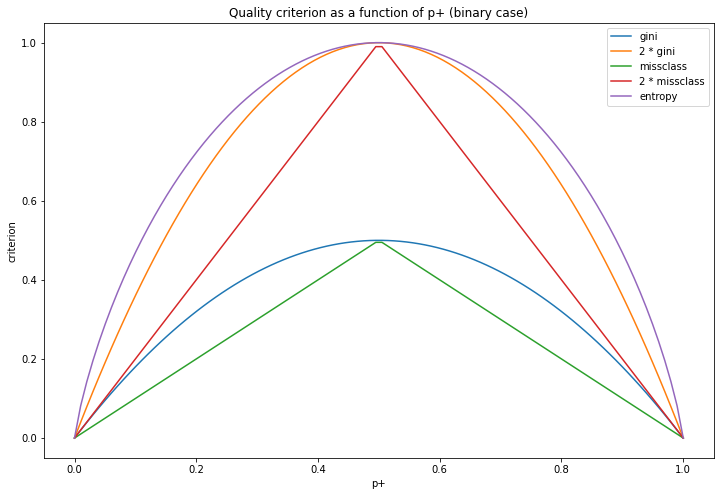

In [6]:
plt.figure(figsize=(12, 8))

grid = np.linspace(0, 1, 100)
gini = 2 * grid * (1 - grid)
missclass = 1 - np.maximum(grid, 1 - grid)  # np.maximum - elementwise function unlike np.max
eps = 1e-10  # for numerical stability
entropy = -grid * np.log2(grid + eps) - (1 - grid) * np.log2(1 - grid + eps)

plt.plot(grid, gini, label="gini")
plt.plot(grid, 2 * gini, label="2 * gini")
plt.plot(grid, missclass, label="missclass")
plt.plot(grid, 2 * missclass, label="2 * missclass")
plt.plot(grid, entropy, label="entropy")

plt.xlabel("p+")
plt.ylabel("criterion")
plt.title("Quality criterion as a function of p+ (binary case)")
plt.legend()
plt.show()

## Regression criteria
In regression tasks the default choice of stopping criteria is the variance of objects in the leaf:
$$
H_R(R_m) = \frac{1}{N_m} \sum_{(x_i,\,y_i) \in R_m} \left(y_i-\frac{1}{N_m}\sum_{(x_i,\,y_i) \in R_m} y_j \right)^2.
$$

However, different criteria are possible - for example, Mean Absolute Deviation from the median.

# Stopping criteria

For any training set it is possible to construct a decision tree perfectly fitting this sample. That is, the training error can be minimized to zero.

If we consider objects as points in the feature space, each of those points (training objects) can be surrounded by a n-dimensional cube, not containing any other points. That means, we can construct a decision tree, in which all the leaves are such cubes. There will be $n$ leaves ($n$ - the size of training data), and the error will be 0.

However, such an approach will lead to **severe overfitting**. In general, decision trees can fit very complicated dependencies and are prone to overfitting.

That leads to the question - how can we determine, if we should stop splitting the data and call the current node a leaf?

Let's look at a toy regression task.
Objects will be points on 2-dim surface, and a target label will be the distance between the point and the center of coordinates (0, 0).

In [7]:
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(
        np.arange(x_min, x_max, 0.01),
        np.arange(y_min, y_max, 0.01),
    )

First, we generate the dataset.

In [8]:
data_x = np.random.normal(size=(100, 2))
data_y = (data_x[:, 0] ** 2 + data_x[:, 1] ** 2) ** 0.5

Visualization.

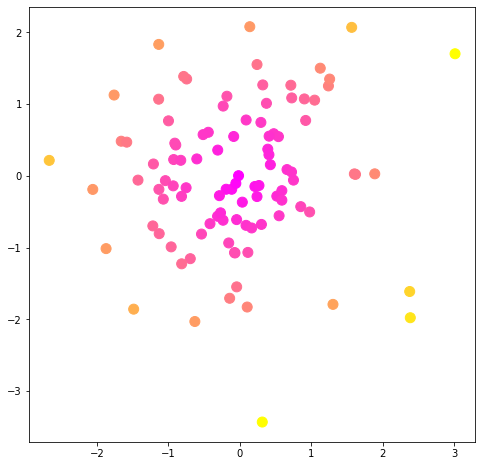

In [9]:
plt.figure(figsize=(8, 8))
plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=100, cmap="spring")

Train the regressor

In [10]:
clf = DecisionTreeRegressor()
clf.fit(data_x, data_y)

DecisionTreeRegressor()

Let's take a look at the predictions

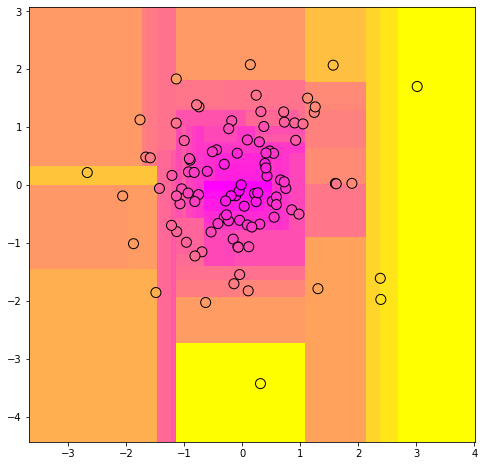

In [11]:
xx, yy = get_grid(data_x)

predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(8, 8))
plt.pcolormesh(xx, yy, predicted, cmap="spring", shading="auto")
plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=100, cmap="spring", edgecolor="k")

Now let's see how the decision surface will look like depending on:
- minimal num. of objects inside a leaf
- maximal depth of the tree

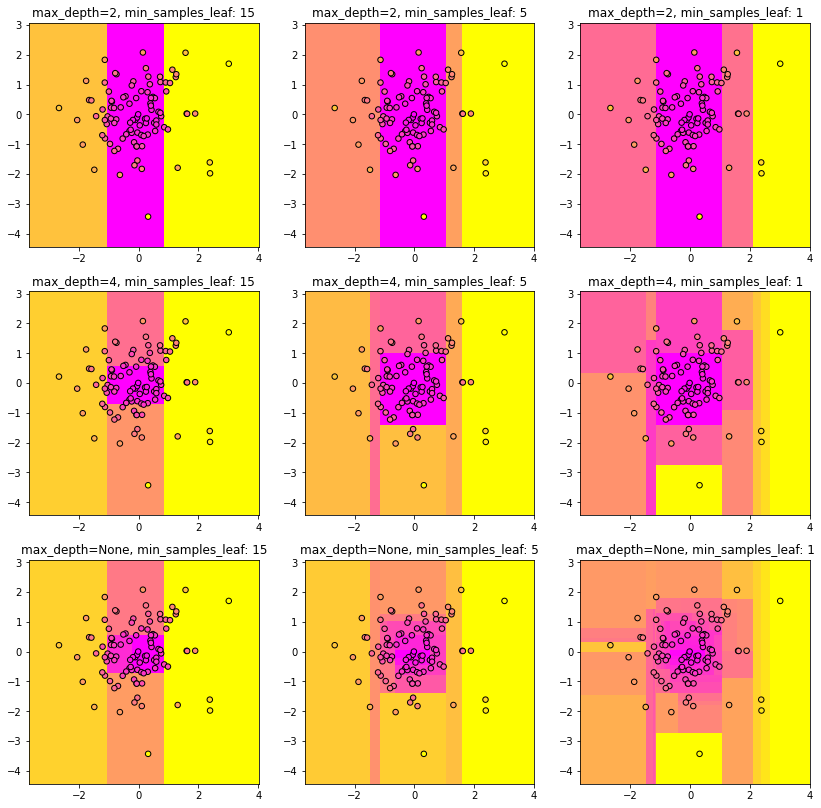

In [12]:
plt.figure(figsize=(14, 14))

for i, max_depth in enumerate([2, 4, None]):
    for j, min_samples_leaf in enumerate([15, 5, 1]):

        clf = DecisionTreeRegressor(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
        clf.fit(data_x, data_y)

        xx, yy = get_grid(data_x)
        predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

        plt.subplot2grid((3, 3), (i, j))
        plt.pcolormesh(xx, yy, predicted, cmap="spring", shading="auto")
        plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=30, cmap="spring", edgecolor="k")
        plt.title("max_depth=" + str(max_depth) + ", min_samples_leaf: " + str(min_samples_leaf))

**Conclusion**
- We can clearly see that large values of max. depth and low values of min. number of leaf objects lead to near-perfect training data scores and overfitting.

## Instability of decision trees

Decision trees are not very stable: if we slighly change the training set, the resulting classifier may change radically.
Let's see an example of this property. We are going to train the tree on different 90% subsamples from the training data and look at the tree structure for those subsets.


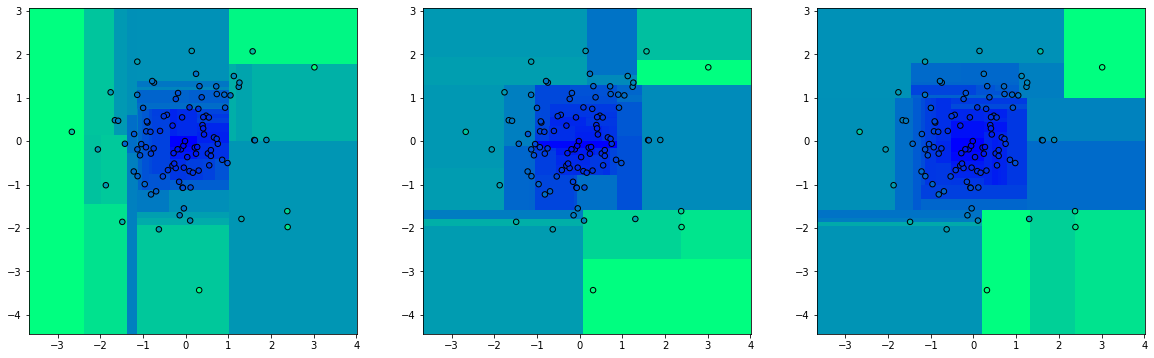

In [13]:
plt.figure(figsize=(20, 6))

for i in range(3):
    clf = DecisionTreeRegressor(random_state=42)

    indecies = np.random.randint(data_x.shape[0], size=int(data_x.shape[0] * 0.9))
    clf.fit(data_x[indecies], data_y[indecies])

    xx, yy = get_grid(data_x)
    predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    plt.subplot2grid((1, 3), (0, i))
    plt.pcolormesh(xx, yy, predicted, cmap="winter", shading="auto")
    plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=30, cmap="winter", edgecolor="k")

### Working with categorical features 

There are several approaches to work with categorical features in decision trees:

* One-hot encoding, Mean target encoding, binary encoding
* In some frameworks (CatBoost), the number of outgoing edges in the node can differ from 2. In case of a categorical split, we may create n outgoing edges (where n is the number of categories). This will inherently take into account each category.


# Pros and cons of Decision Trees:

**Pros**
 * Interpretability
 * Easy to use for both regression and classification
 * Can work with heterogenuous data
 
**Cons**
 * If the set is linearly divisible, linear models perform much better
 * Prone to overfitting
 * Instability to noise, training set change, criterion change etc.
 
**Possible ways to improve the algorithm**
 * Pruning
 * Compositions of multiple trees (bagging, Random Forest)